# TODO:
- Return intermediate nodes after transformation

- Retain pytree structure after transformation

- vmap + non-centered transformation?

- Cannot sample from auto_vmap(qs)???

- When pulling out constant parents, we should have parents of format [0 1 2] rather than [RV(Constant(0)) RV(Constant(1)) RV(Constant(2))]

In [31]:
w = [makerv(0), makerv(1)]
z1 = normal_scale(0, 1)
y = vmap(lambda _w: normal_scale(_w * z1, 1), 0)(tuple(w))

IndexError: tuple index out of range

In [35]:
jnp.array([jnp.array([0 + i, 1, 2]) for i in range(3)]).shape

(3, 3)

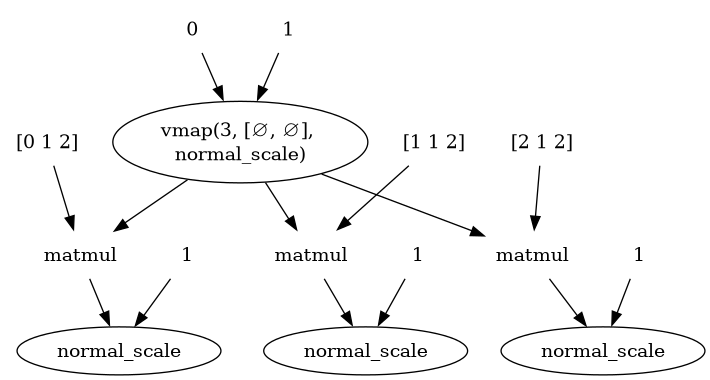

In [36]:
display(viz_upstream(y))

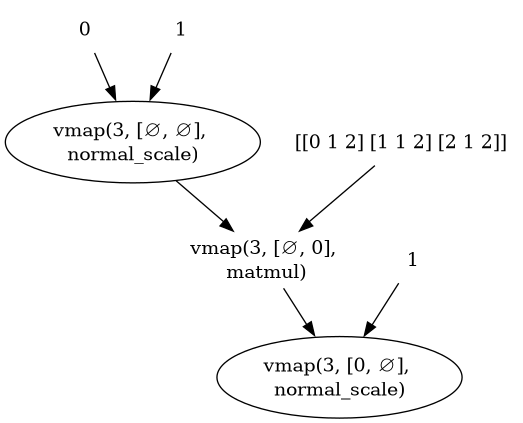

In [33]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = makerv([[0 + i, 1, 2] for i in range(3)])
# y = [normal_scale(z1 @ w[i], 1) for i in range(3)]
# display(viz_upstream(y))

y_vmapeed = vmap(lambda _w: normal(z1 @ _w, 1), 0)(w)
display(viz_upstream(y_vmapeed))

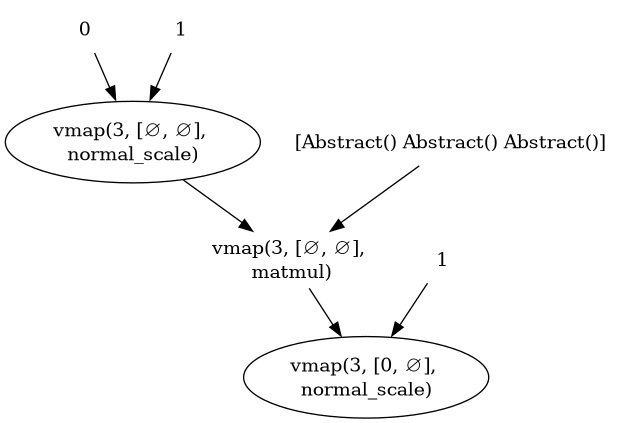

In [23]:
viz_upstream(vmap(lambda _w: normal(z1 @ _w, 1), 0)(w))

In [21]:
print_upstream(vmap(lambda _w: normal(z1 + _w, 1), 0)(makerv(w)))

AssertionError: all parents must have shape ()

In [15]:
%load_ext autoreload
%autoreload 2
import pangolin
from pangolin import transforms
from pangolin.interface import (
    vmap, normal_scale, normal, RV, VMapDist,
    makerv, viz_upstream, exponential, bernoulli, print_upstream
)
from pangolin import dag
from pangolin import new_infer as infer
import jax
from jax import numpy as jnp
from itertools import groupby
import time
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def _is_the_same(node1, node2):
    # Simplify things a little bit?
    def _check_constant_value_equal(v1, v2):
        if hasattr(v1, 'cond_dist'):
            return v1.cond_dist.value == v2.cond_dist.value
        else:
            return v1 == v2
    Constant = pangolin.interface.Constant
    if isinstance(node1.cond_dist, Constant) and isinstance(node2.cond_dist, Constant):
        if node1.shape:
            return all(_check_constant_value_equal(v1, v2)
                       for v1, v2 in zip(node1.cond_dist.value, node2.cond_dist.value))
        return node1.cond_dist.value == node2.cond_dist.value
    return node1 == node2

def merge_if_same(my_list):
    my_list_flattened = jax.tree_util.tree_flatten(my_list)[0]
    if all(
        _is_the_same(element, my_list_flattened[0]) for element in my_list_flattened
    ):
        return my_list_flattened[0], True
    return my_list, False

def get_constructor(node):
    # We only support dist or a single wrap of vmap dist
    # things could go wrong if we have nested vmap dist.
    assert isinstance(node, RV)
    cond_dist = node.cond_dist
    # Get a constructor for the distribution
    if isinstance(cond_dist, VMapDist):
        base_dist, in_axes, axis_size = cond_dist.base_cond_dist, cond_dist.in_axes, cond_dist.axis_size
        def _constructor(*args):
            args = tuple([makerv(arg) for arg in args])
            return vmap(base_dist, in_axes, axis_size)(*args)
        return _constructor
    else:
        base_dist = cond_dist
        def _constructor(*args):
            return base_dist(*args)
        return _constructor
    raise NotImplementedError
    
def process_parents_for_vmap(parents):
    in_axes = ()
    args = []
    for p in parents:
        if isinstance(p, list) or isinstance(p, tuple):
            print(p)
            axis_size = len(p)
            p, merged = merge_if_same(p)
            in_axes = in_axes + (None,) if merged else in_axes + (0,)
            # p = list(p)
        elif isinstance(p.cond_dist, VMapDist):
            in_axes = in_axes + (0,)
            axis_size = p.shape[0]
        args.append(p)
        print()
    return args, in_axes, axis_size

def list_to_vmap(nodes):
    if isinstance(nodes, tuple):
        nodes = list(nodes)
    if not isinstance(nodes, list):
        return nodes
    constructor = get_constructor(nodes[0])
    parent_args = zip(*[node.parents for node in nodes])
    # Merge identical parents if possible,
    # For identical parent, in_axes=None, otherwise in_axes=0
    args, in_axes, axis_size = process_parents_for_vmap(parent_args)
    # Re-construct the nodes using vmap
    print(in_axes)
    vmapped_node = vmap(constructor, in_axes, axis_size)(*args)
    return vmapped_node

def find_common_parent(nodes):
    # Assume nodes are flattened
    first_node = nodes[0]
    num_args = len(first_node.parents)
    for i, p in enumerate(first_node.parents):
        if all(
            p == n.parents[i] for n in nodes
        ):
            return p
    return None

def group_nodes(nodes, group_axis=None):
    nodes_flattened, _ = jax.tree_util.tree_flatten(nodes)
    first_node = nodes_flattened[0]
    assert all(
        str(n.cond_dist) == str(first_node.cond_dist) for n in nodes_flattened
    )
    # Then we group the nodes
    if group_axis is None:
        for i, p in enumerate(first_node.parents):
            if not isinstance(p.cond_dist, Constant):
                group_axis = i
                break
    grouped_nodes = [list(v) for k, v in groupby(nodes_flattened, lambda x: x.parents[group_axis])]
    return grouped_nodes, group_axis

def get_parents(nodes):
    parent_list = list(zip(*[node.parents for node in nodes]))
    parent_list = [list(p) for p in parent_list]
    vmap_idx = None
    for idx, pl in enumerate(parent_list):
        if pl[0].parents:
            vmap_idx = idx
    return parent_list, vmap_idx # this is little bit weird

def vmap_parent_and_merge(nodes):
    if isinstance(nodes, tuple):
        nodes = list(nodes)
    if isinstance(nodes, RV):
        return nodes
    common_parent = find_common_parent(nodes)
    if common_parent:
        nodes = list_to_vmap(nodes)
        return nodes
    parents, vmap_idx = get_parents(nodes)
    parents[vmap_idx] = vmap_parent_and_merge(parents[vmap_idx])
    args, in_axes, axis_size = process_parents_for_vmap(parents)
    new_node = vmap(get_constructor(nodes[0]), in_axes, axis_size)(*args)
    return new_node

def _is_grouppable(nodes):
    node_idx = list(range(len(nodes)))
    augmented_node_list = [(idx, n) for idx, n in zip(node_idx, nodes)]
    grouped_result = [
        list(v) for k, v in groupby(augmented_node_list, lambda X: X[1])
    ]
    if len(grouped_result) == len(augmented_node_list):
        return None
    else:
        return [[idx for idx, node in group] for group in grouped_result]
    
def group_by_lowest_ancestor(nodes):
    grouppable = _is_grouppable(nodes)
    if grouppable:
        return grouppable
    for parent in get_parents(nodes)[0]:
        parent_grouppable = group_by_lowest_ancestor(parent)
        if parent_grouppable:
            return parent_grouppable
    return None

def flatten_group_and_merge(nodes):
    nodes = jax.tree_util.tree_flatten(nodes)[0]
    group_idx = group_by_lowest_ancestor(nodes)
    if not group_idx:
        return nodes
    nodes_grouped = [[nodes[idx] for idx in group] for group in group_idx]
    nodes_merged = [vmap_parent_and_merge(group) for group in nodes_grouped]
    return nodes_merged

In [7]:
def auto_vmap(nodes):
    while True:
        nodes_transformed = flatten_group_and_merge(nodes)
        if nodes == nodes_transformed:
            break
        nodes = nodes_transformed
    return nodes

# TL;DR

Here is how it works

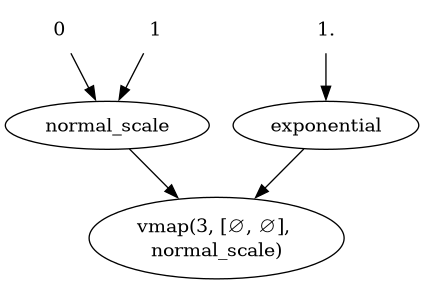

In [4]:
z1 = normal_scale(0, 1)
z2 = exponential(1.0)
y = [normal_scale(z1, z2) for i in range(3)]
viz_upstream(auto_vmap(y))

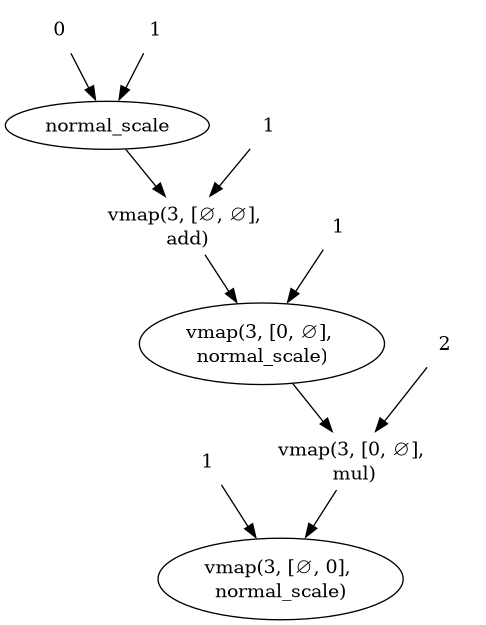

In [5]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [normal_scale(1, y[i] * 2) for i in range(3)]
display(viz_upstream(auto_vmap(x)))

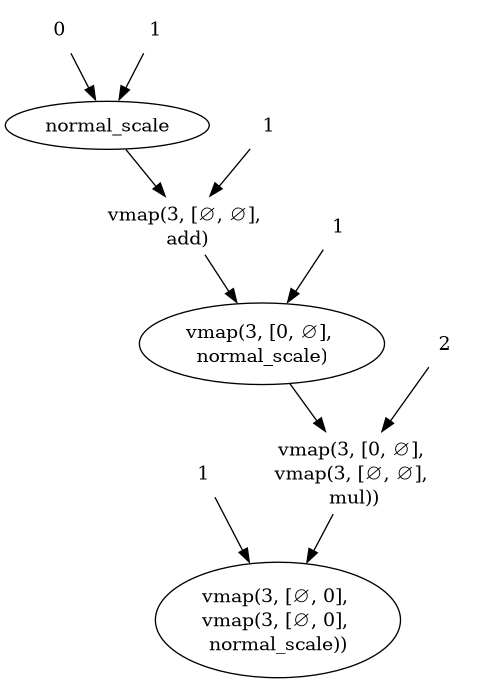

In [6]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [[normal_scale(1, y[i] * 2) for j in range(3)] for i in range(3)]
display(viz_upstream(auto_vmap(x)))

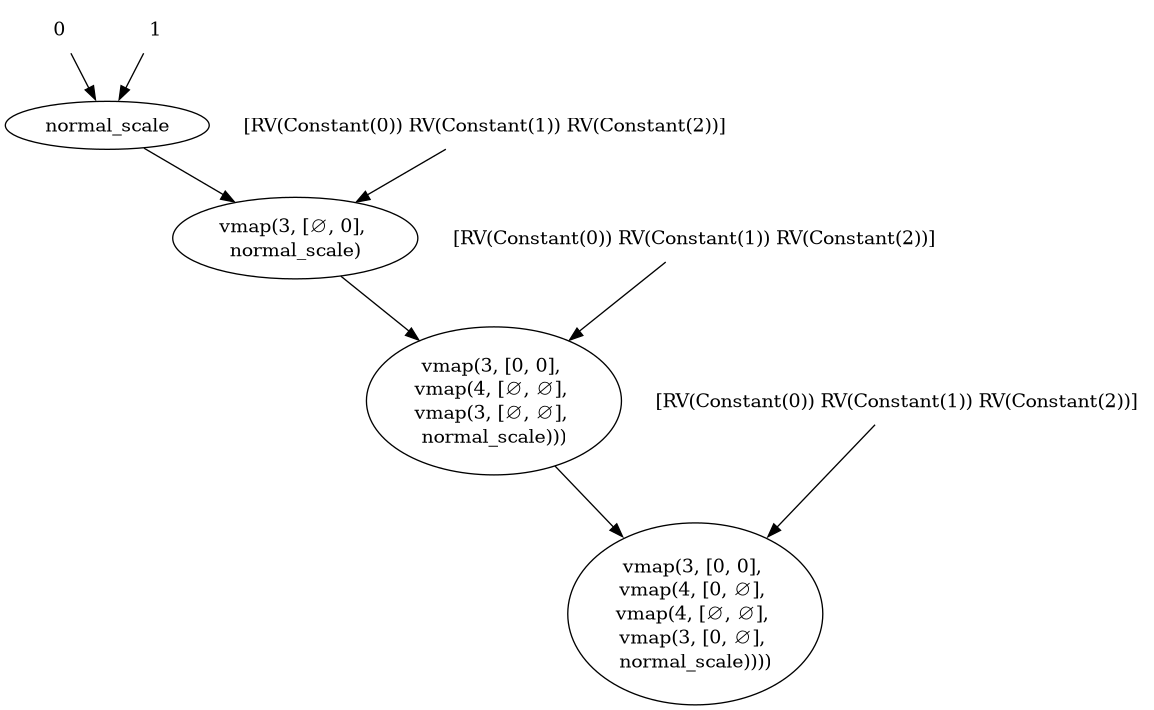

In [7]:
z = normal(0, 1)
xs = {}
ys = {}
qs = {}
for i in range(3):
    xs[i] = normal(z, i)
    for j in range(4):
        ys[(i, j)] = vmap(normal, None, 3)(xs[i], i)
        for k in range(4):
            qs[(i, j, k)] = vmap(normal, (0, None))(ys[(i, j)], i)

display(viz_upstream(
    auto_vmap(qs)
))

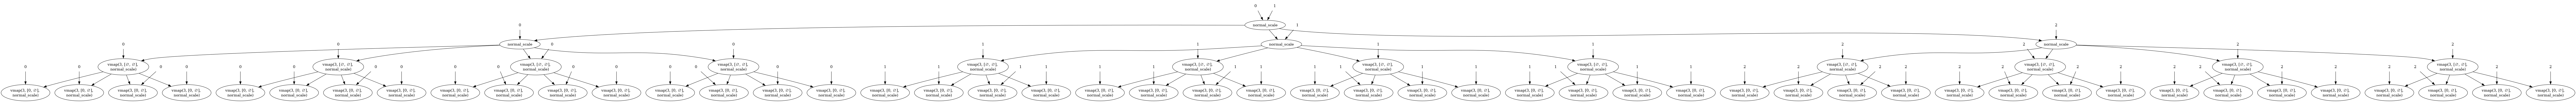

In [228]:
# Unvmapped version
viz_upstream(qs)

## ???????

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


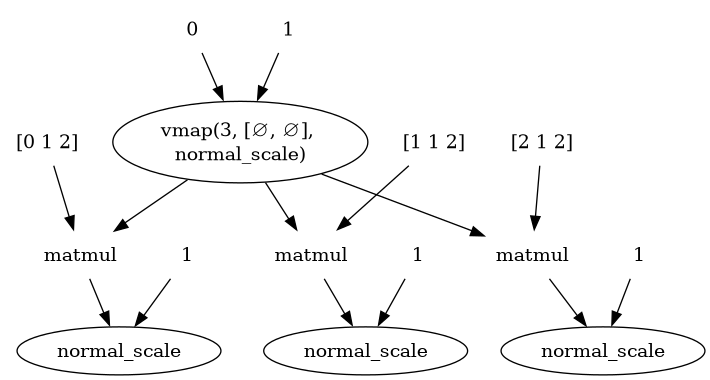

In [3]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = jnp.array([jnp.array([0 + i, 1, 2]) for i in range(3)])
y = [normal_scale(z1 @ w[i], 1) for i in range(3)]
display(viz_upstream(y))

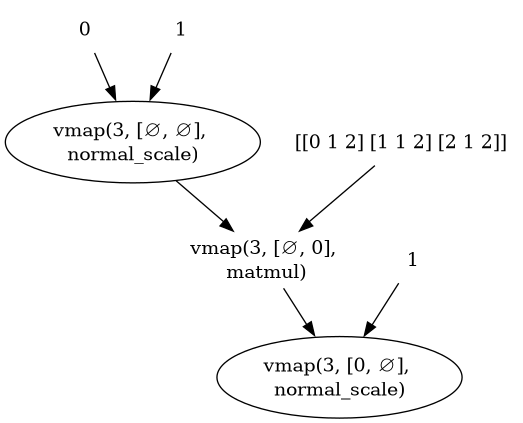

In [37]:
y_vmapped = vmap(lambda _w: normal_scale(z1 @ _w, 1), 0)(makerv(w))
display(viz_upstream(y_vmapped))

In [38]:
z = normal(0, 1)
x = vmap(normal_scale, (None, 0))(z, jnp.array([1,2,3]))
infer.sample(x)

skipping MCMC...


Array([[-1.4100333 , -0.574007  ,  3.0961292 ],
       [-2.5433795 , -3.4892206 ,  5.872308  ],
       [-0.6811749 , -1.240486  ,  3.660831  ],
       ...,
       [ 1.4952509 , -2.7758555 ,  0.87634593],
       [-1.1171294 , -2.5931957 ,  4.8771625 ],
       [ 1.6560953 ,  3.9696844 ,  3.6912088 ]], dtype=float32)

In [39]:
infer.sample(auto_vmap(qs))

NameError: name 'qs' is not defined

# Timing

In [229]:
z = normal_scale(0, 1)
y = [normal_scale(i, 1) for i in range(10)]
x = [[normal(y[i], 1) for j in range(200)] for i in range(10)]

In [ ]:
%timeit infer.sample(x)

skipping MCMC...
skipping MCMC...
skipping MCMC...
skipping MCMC...


In [ ]:
z = normal_scale(0, 1)
y = [normal_scale(i, 1) for i in range(10)]
x = [[normal(y[i], 1) for j in range(200)] for i in range(10)]
x_vmapped = auto_vmap(x)

In [ ]:
%timeit infer.sample(x_vmapped)

# Here are the explanations

In short, we have three cases:

# Base case (case 0)

The simplest case would be where all leaf nodes can be direclty merged with their single parent, in this case we can call `list_to_vmap`

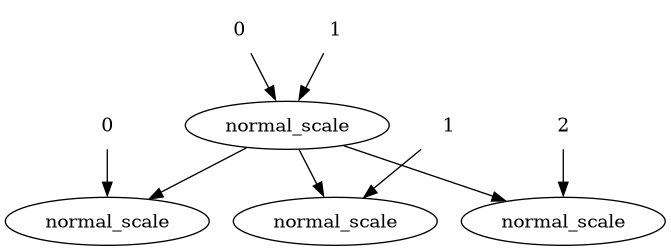

In [91]:
z = normal_scale(0, 1)
y = [normal_scale(z, i) for i in range(3)]
viz_upstream(y)

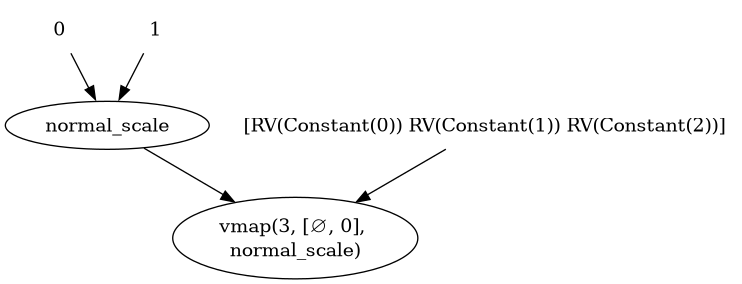

In [17]:
viz_upstream(list_to_vmap(y))

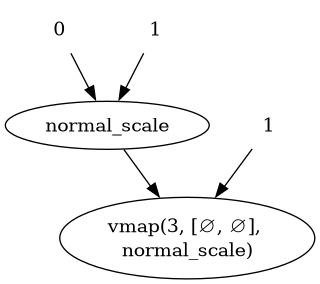

In [18]:
z = normal_scale(0, 1)
y = [normal_scale(z, 1) for i in range(3)]
viz_upstream(list_to_vmap(y))

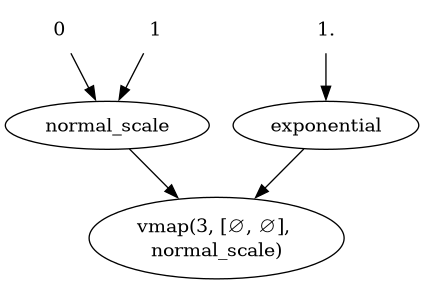

In [19]:
z1 = normal_scale(0, 1)
z2 = exponential(1.0)
y = [normal_scale(z1, z2) for i in range(3)]
viz_upstream(list_to_vmap(y))

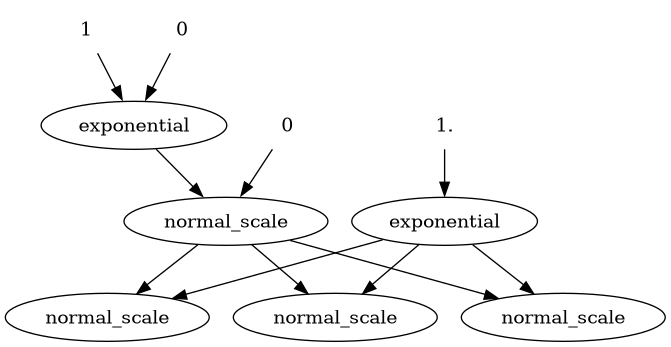

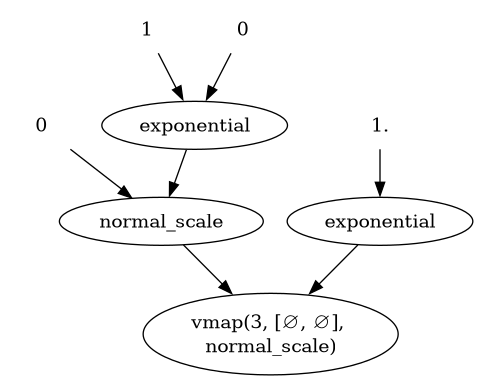

In [20]:
z0 = exponential(1,0)
z1 = normal_scale(0, z0)
z2 = exponential(1.0)
y = [normal_scale(z1, z2) for i in range(3)]
display(viz_upstream(y))
viz_upstream(list_to_vmap(y))

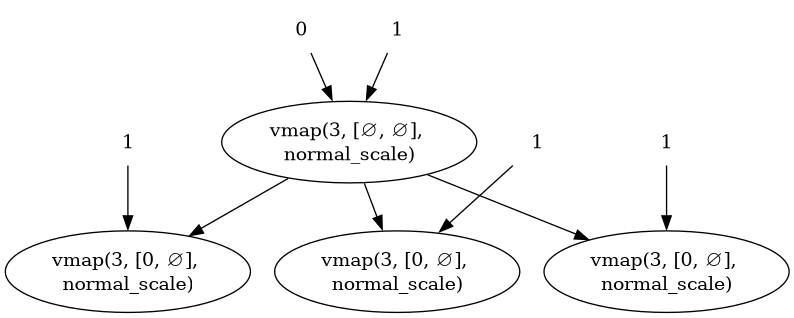

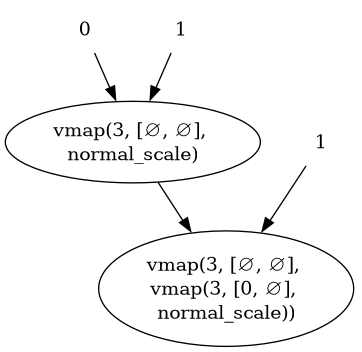

In [21]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = makerv([0, 1, 2])
y = [vmap(normal_scale, (0, None))(z1, 1) for i in range(3)]
display(viz_upstream(y))
viz_upstream(list_to_vmap(y))

Before vmap


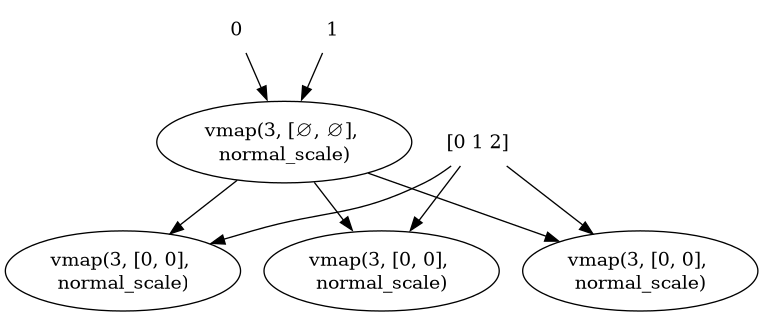

After vmap


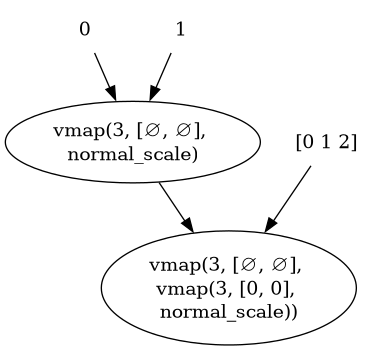

In [88]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = makerv([0, 1, 2])
y = [vmap(normal_scale, (0, 0))(z1, w) for i in range(3)]
print('Before vmap')
display(viz_upstream(y))
print('After vmap')
viz_upstream(list_to_vmap(y))

## However, since we cannot vmap over "a list of constant RV list", the following case cannot work
## Although I think it actually describes many applications, e.g. when the constant represents the feature of data
## In this case we would need to convert the list into a matrix and then vmap over the first dimension.

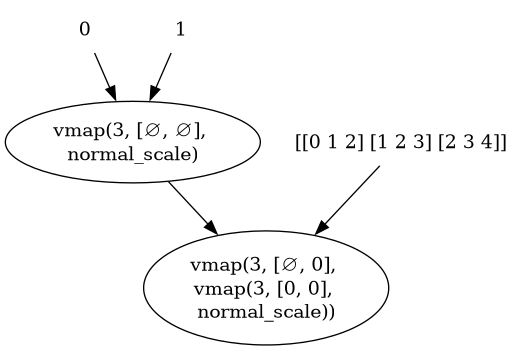

In [8]:
z1 = vmap(normal_scale, None, 3)(0, 1)
# w = [makerv([0 + i, 1, 2]) for i in range(3)]
w = jnp.array([[0, 1, 2], [1, 2, 3], [2, 3, 4]])
y = [vmap(normal_scale, (0, 0))(z1, w[i]) for i in range(3)]
# display(viz_upstream(y))
# viz_upstream(list_to_vmap(y))
viz_upstream(vmap(vmap(normal_scale, (0, 0)), (None, 0))(z1, w))

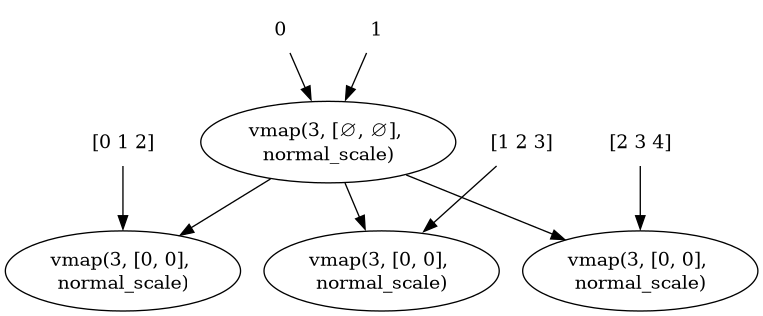

(RV(VMapDist(base_cond_dist=normal_scale), parents=[RV(Constant(0)),RV(Constant(1))]), RV(VMapDist(base_cond_dist=normal_scale), parents=[RV(Constant(0)),RV(Constant(1))]), RV(VMapDist(base_cond_dist=normal_scale), parents=[RV(Constant(0)),RV(Constant(1))]))

(RV(Constant([0,1,2],dtype=int32)), RV(Constant([1,2,3],dtype=int32)), RV(Constant([2,3,4],dtype=int32)))

(None, 0)


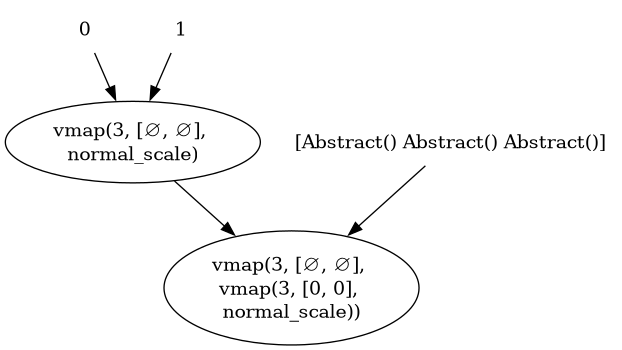

In [9]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = jnp.array([[0, 1, 2], [1, 2, 3], [2, 3, 4]])
y = [vmap(normal_scale, (0, 0))(z1, w[i]) for i in range(3)]
display(viz_upstream(y))
viz_upstream(list_to_vmap(y))

# Base case with intermediate nodes (case 1)

Now assume we have **branches** instead of just leaf nodes of similar structure, and we would like to merge them using vmap, in this case we should call `vmap_parent_and_merge` on the leaf nodes.

This transformation would: Recursively climb up the tree, until we find the level where we can apply `list_to_vmap`, and then rewrite the all the child nodes with vmap.

Note that case 0 is a special case of case 1.

Before vmap


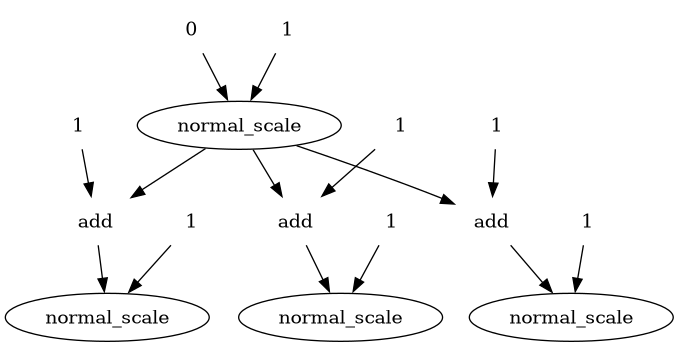

After vmap


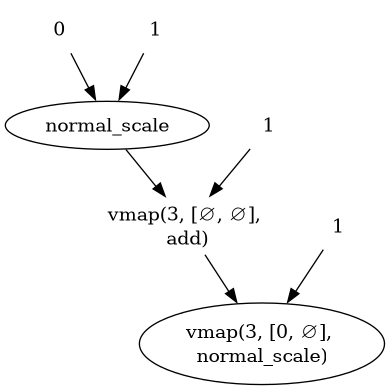

In [22]:
# Add intermediate nodes, "add" to the graph
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
print('Before vmap')
display(viz_upstream(y))
print('After vmap')
display(viz_upstream(vmap_parent_and_merge(y)))

Before vmap


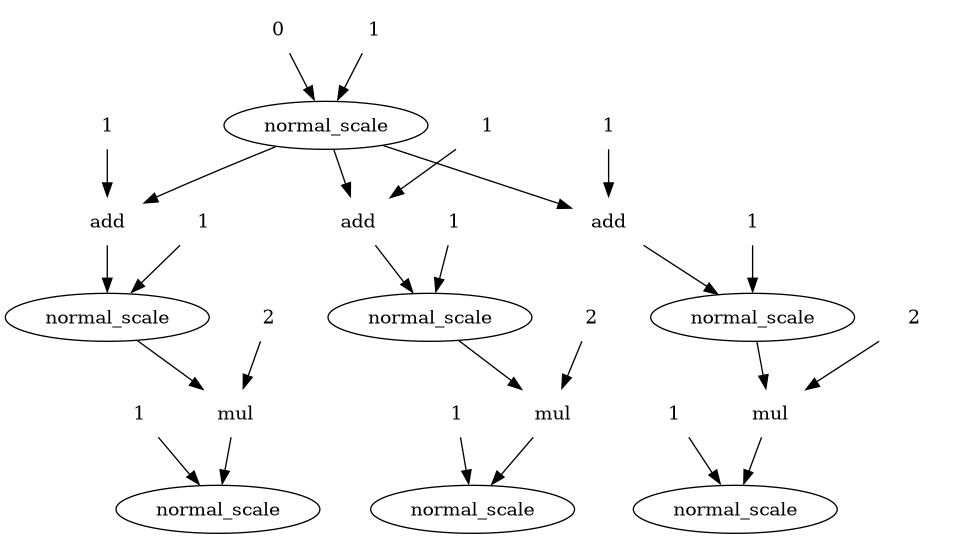

After vmap


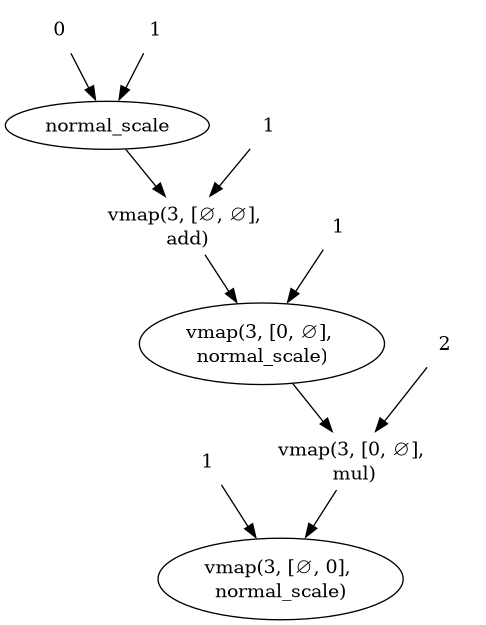

In [23]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [normal_scale(1, y[i] * 2) for i in range(3)]
print('Before vmap')
display(viz_upstream(x))
print('After vmap')
display(viz_upstream(vmap_parent_and_merge(x)))

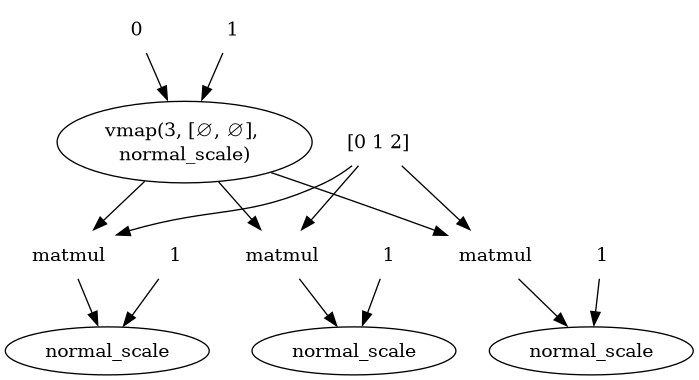

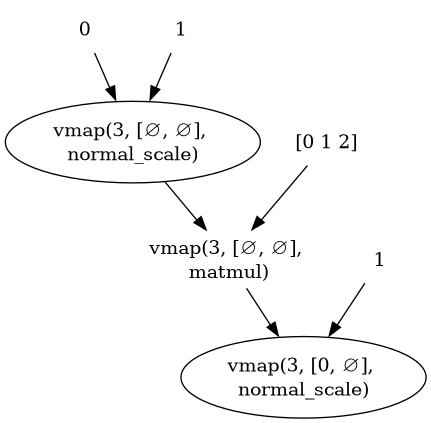

In [26]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = makerv([0, 1, 2])
y = [normal_scale(z1 @ w, 1) for i in range(3)]
display(viz_upstream(y))
viz_upstream(vmap_parent_and_merge(y))

## Still, we cannot handle "a list of constant RVs of list"

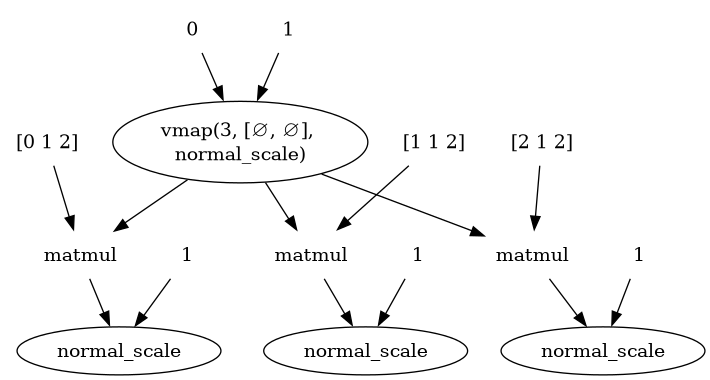

AssertionError: args to @ must have at least 1 dim

In [108]:
z1 = vmap(normal_scale, None, 3)(0, 1)
w = [makerv([0 + i, 1, 2]) for i in range(3)]
y = [normal_scale(z1 @ w[i], 1) for i in range(3)]
display(viz_upstream(y))
viz_upstream(vmap_parent_and_merge(y))

# "Multi group" case (case 2)

In the above examples, we mainly consider trees with branches only in the root node. However, in hierhchical model, we also have branches in intermediate layers.

In this case, we will:


- repeat:
  - Group all leaf nodes according to their **lowest common ancestor**;
  - For all nodes in a group, apply `vmap_parent_and_merge` used in case 1.;
  - Use the vmapped nodes as the new leaf nodes;
- until only one group left


Before vmap


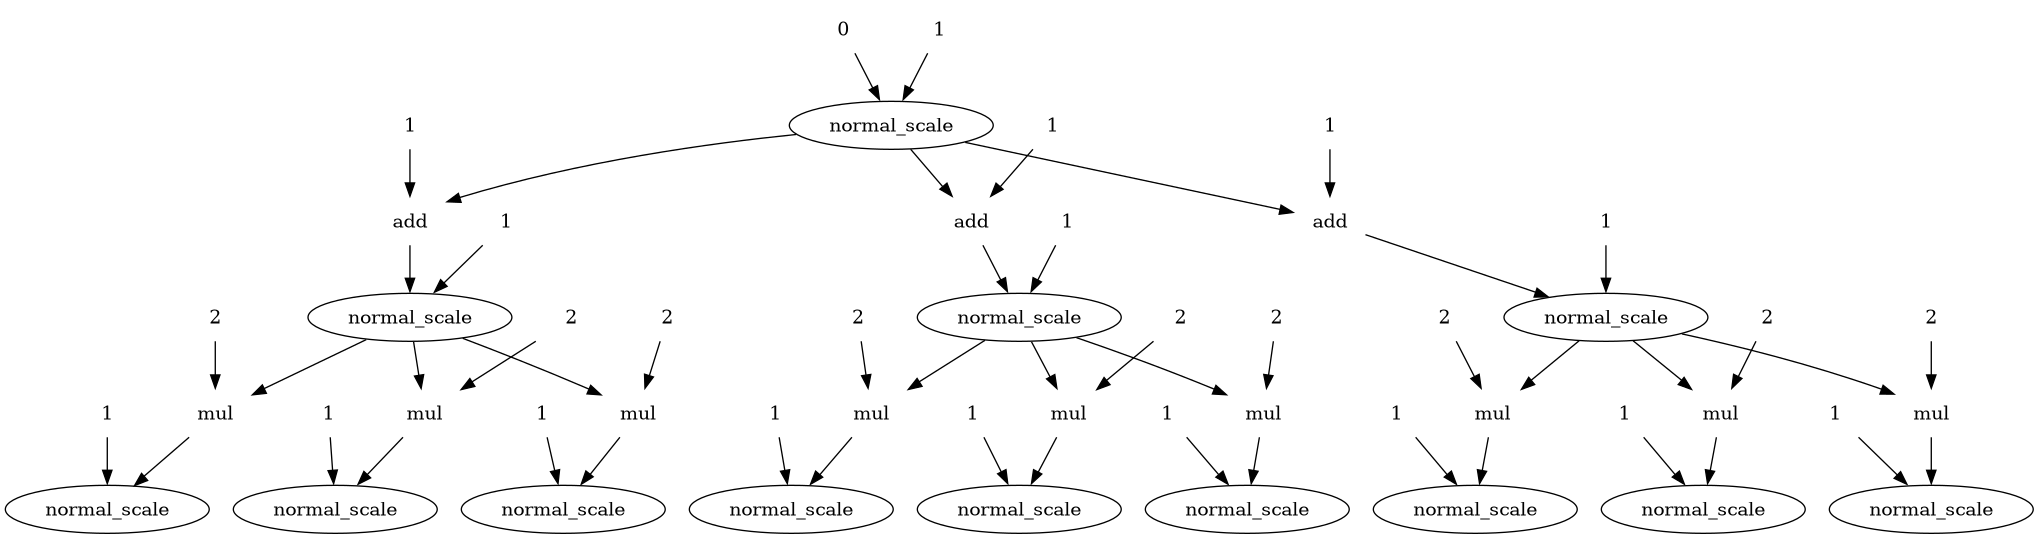

First apply transform on the leaf node


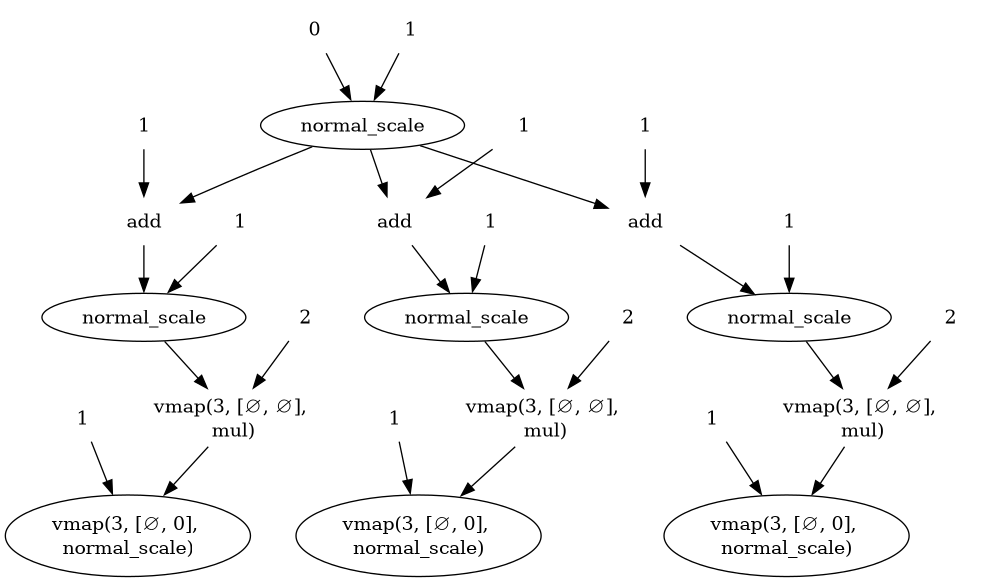

Then we are now back to case 1, we can either call flatten_group_and_merge again or call vmap_parent_and_merge


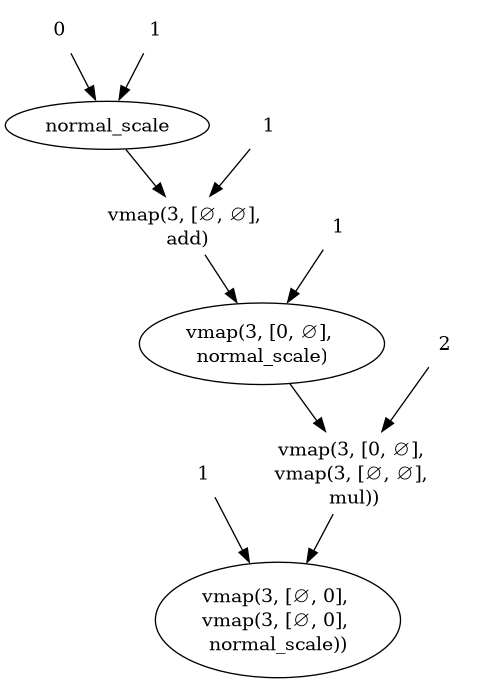

In [28]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [[normal_scale(1, y[i] * 2) for j in range(3)] for i in range(3)]
print('Before vmap')
display(viz_upstream(x))
print('First apply transform on the leaf node')
vmapped_x = flatten_group_and_merge(x)
display(viz_upstream(vmapped_x))
print('Then we are now back to case 1, we can either call flatten_group_and_merge again or call vmap_parent_and_merge')
display(viz_upstream(vmap_parent_and_merge(vmapped_x)))
# print('After vmap')
# display(viz_upstream(vmap_parent_and_merge(x)))

Before vmap


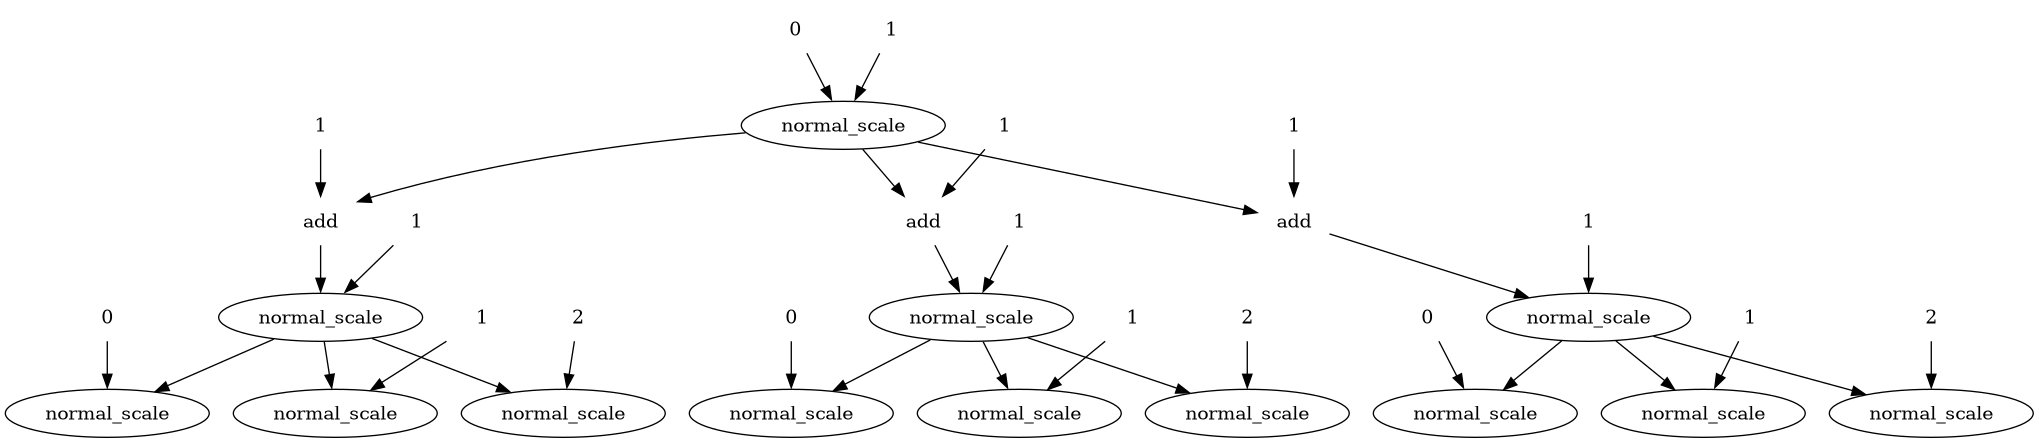

First apply transform on the leaf node


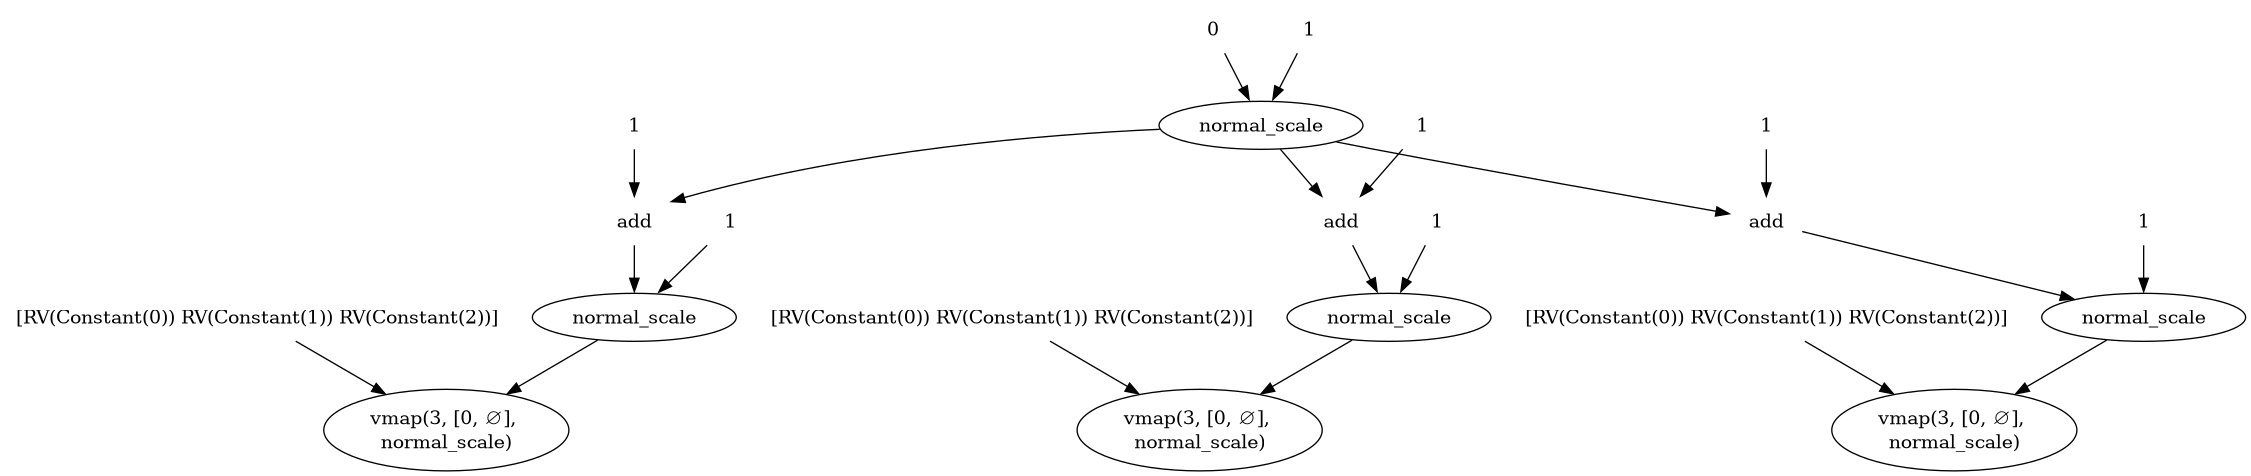

Continue simplifying


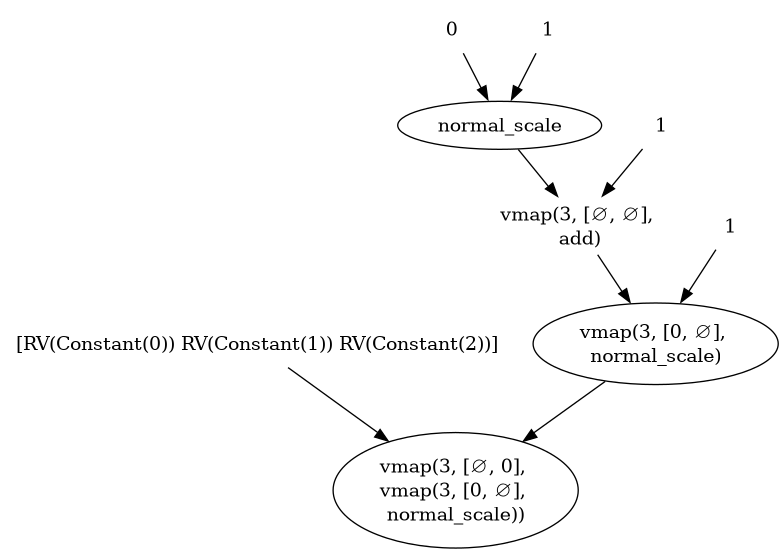

In [29]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [[normal_scale(j, y[i]) for j in range(3)] for i in range(3)]
print('Before vmap')
display(viz_upstream(x))
print('First apply transform on the leaf node')
vmapped_x = flatten_group_and_merge(x)
display(viz_upstream(vmapped_x))
print('Continue simplifying')
display(viz_upstream(vmap_parent_and_merge(vmapped_x)))

In practice, we can just keep calling `vmap_parent_and_merge` (which is what `auto_vmap` does) till the output stays unchanged

In [40]:
z = normal(0, 1)
xs = {}
ys = {}
qs = {}
for i in range(3):
    xs[i] = normal(z, i)
    for j in range(4):
        ys[(i, j)] = normal(xs[i], i)
        for k in range(4):
            qs[(i, j, k)] = normal(ys[(i, j)], 1)
            
display(viz_upstream(
    flatten_group_and_merge(flatten_group_and_merge(flatten_group_and_merge(qs)))
))

(RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]), RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]), RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]), RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]))

(RV(Constant(1)), RV(Constant(1)), RV(Constant(1)), RV(Constant(1)))

(None, None)
(RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]), RV(normal_scale, parents=[RV(normal_scale, parents=[RV(normal_scale, parents=[RV(Constant(0)),RV(Constant(1))]),RV(Constant(0))]),RV(Constant(0))]), RV(normal_scale, par

IndexError: tuple index out of range

Again, if the leaf nodes are heterogeneous, we would run into trouble

Before vmap


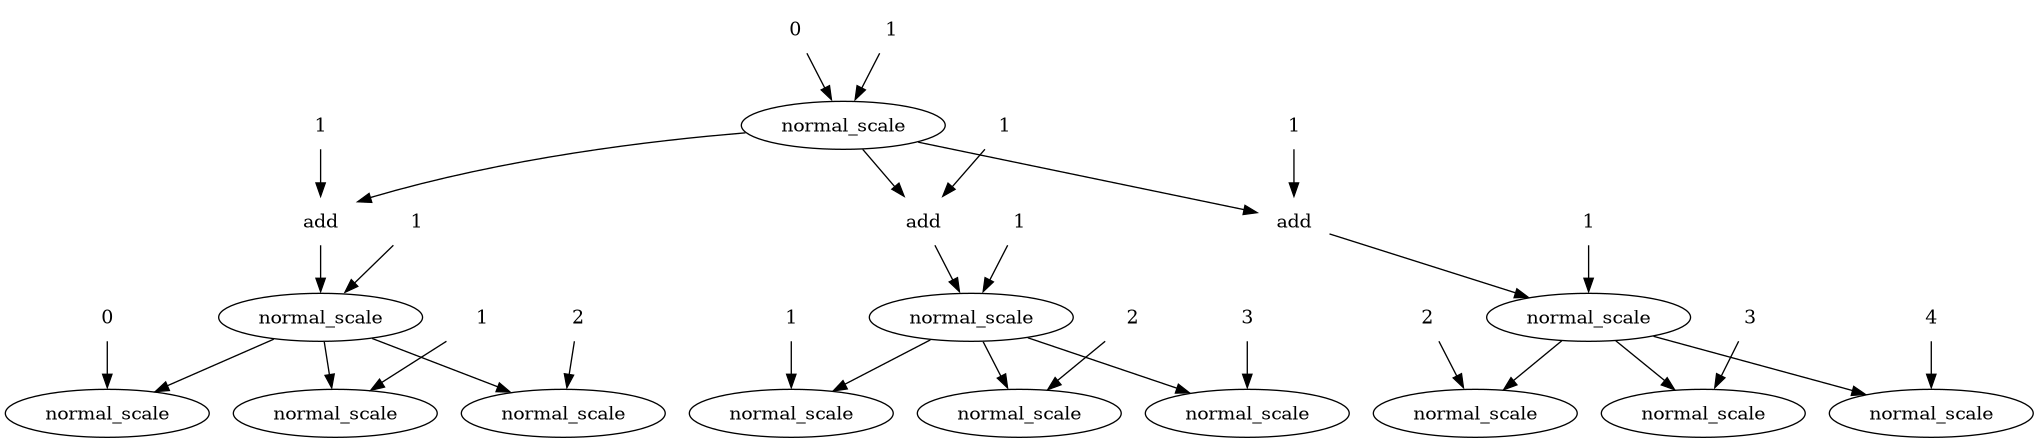

First apply transform on the leaf node


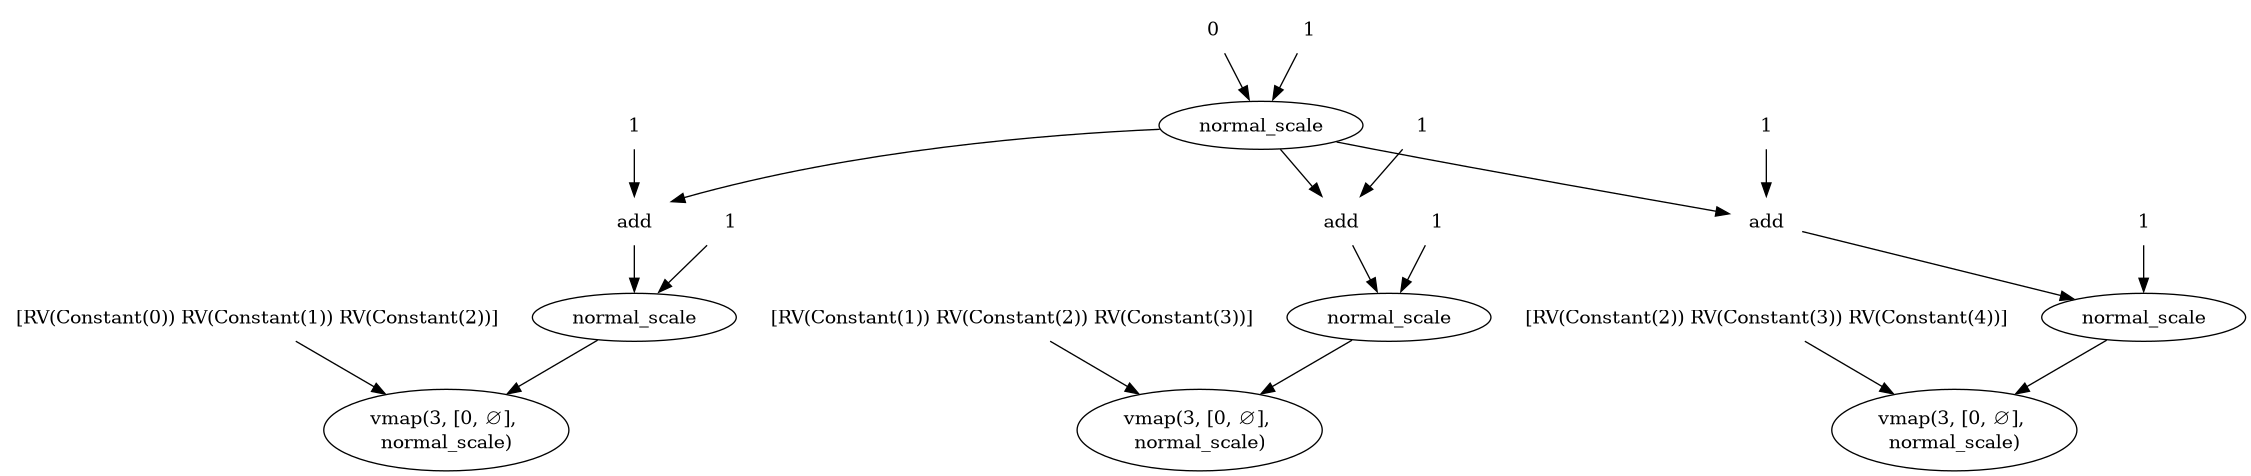

Continue simplifying


IndexError: tuple index out of range

In [30]:
z = normal_scale(0, 1)
y = [normal_scale(z + 1, 1) for _ in range(3)]
x = [[normal_scale(j + i, y[i]) for j in range(3)] for i in range(3)]
print('Before vmap')
display(viz_upstream(x))
print('First apply transform on the leaf node')
vmapped_x = flatten_group_and_merge(x)
display(viz_upstream(vmapped_x))
print('Continue simplifying')
display(viz_upstream(vmap_parent_and_merge(vmapped_x)))

# Let's do movie lens! 

OK, it cannot work at this moment as we need to vmap over the list of constant rv list.

In [83]:
users = {}
theta = normal(0, 1)
for uid in range(3):
    users[uid] = vmap(normal, None, 5)(theta, 5)
movies_features = {}
for mid in range(10):
    movies_features[mid] = makerv(jnp.ones((5,)) * mid / 2)
ratings = {}
user_watch_history = {}
user_watch_history[0] = [0, 1, 2]
user_watch_history[1] = [0, 1, 9]
user_watch_history[2] = [0, 2, 3]
for uid in range(1):
    for mid in user_watch_history[uid]:
        ratings[(uid, mid)] = bernoulli(movies_features[mid] @ users[uid])